In [ ]:
# Copyright 2021The Authors. All Rights Reserved.
#
# GNU General Public License v3.0
# Permissions of this strongest copyleft license are conditioned on 
# making available complete source code of licensed works and modifications, 
# which include larger works using a licensed work, under the same license. 
# Copyright and license notices must be preserved. 
# Contributors provide an express grant of patent rights. 
# When a modified version is used to provide a service over a network, 
# the complete source code of the modified version must be made available.
# ==============================================================================

# Title: CRISPR direct repeats data processing
# Author: Hyunjin Shim
# Date created: 20210511
# Email: jinenstar@gmail.com

# CRISPR repeat data processing and patterns
- to process CRISPR repeats from CRISPR-Cas++
- to cluster CRISPR repeats by type
- to perform dimensionality reduction to identify patterns
- to visualize the results after each experimentation
- to interpret results with biological features

# Dataset description
- Total: 26,958 repeats (downloaded 20210511)
- Classified: some repeats classified by  from CRISPR-Cas++ (CRISPR_repeat_data_processing.ipynb): Cas-CRISPR_DR in one-to-one association only

In [291]:
# Data
import os
from pathlib import Path 
import glob
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple

# Biopython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Regular expression
import re

# Plot
#from pylab import *
#import pylab as pylab
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import itertools

# Math
import math
from statistics import mean, stdev
import random
random.seed(10)

In [292]:
# Functions
nt_vocab = {"<pad>":0, "T":1, "A":2, "G":3, "C":4, "t":1, "a":2, "g":3, "c":4, "N":0, "n":0, "K":0, "k":0, "Y":0, "y":0, "M":0, "m":0, "R":0, "r":0, "W":0, "w":0, "S":0, "s":0, "H":0, "h":0, "B":0, "b":0, "D":0, "d":0, ".":"", "(":"", ")":""}

def extract_dataset_info(records: List[SeqRecord]) -> Dict: 
    # Contains information on dataset
    seqs_id = [r.id for r in records]
    seqs_len = [len(r.seq) for r in records]
    seqs = [str(r.seq) for r in records]
    int_seqs = [[nt_vocab[nt] for nt in s] for s in seqs]
    d = {"ID":seqs_id, "Seq":seqs, "Int_Seq":int_seqs, "Length":seqs_len}
    return d

def extract_dataset_mfe(records: List[SeqRecord]) -> Dict: 
    # Contains information on dataset
    seqs_id = [r.id for r in records]
    seqs_mfe = [str(r.seq) for r in records]
    d = {"ID":seqs_id, "MFE":seqs_mfe}
    return d

def calculate_GC_content(Seq): 
    GC_bySeq = [None] * len(Seq)
    for i in range(len(Seq)):
        T=0; A=0; G=0; C=0
        T = T+Seq[i].count("T")
        A = A+Seq[i].count("A")
        G = G+Seq[i].count("G")
        C = C+Seq[i].count("C")
        GC_bySeq[i] = (G+C)/(T+A)
    return mean(GC_bySeq), stdev(GC_bySeq) if len(GC_bySeq) > 1 else None

def calculate_Shannon_E(Seq):
    all_Shannon = [None]*len(Seq)
    all_Entropy = [None]*len(Seq)
    
    for i in range(len(Seq)): 
        Seq_len = len(Seq[i])
        f1 = Seq[i].count('T')/Seq_len
        f2 = Seq[i].count('A')/Seq_len
        f3 = Seq[i].count('G')/Seq_len
        f4 = Seq[i].count('C')/Seq_len
        all_Shannon[i] = -((f1*(math.log(f1,2) if f1 != 0 else 0)) + (f2*(math.log(f2,2) if f2 != 0 else 0)) + (f3*(math.log(f3,2) if f3 != 0 else 0)) + (f4*(math.log(f4,2) if f4 != 0 else 0)))
        all_Entropy[i] = all_Shannon[i]/Seq_len
    return mean(all_Entropy), stdev(all_Entropy) if len(all_Entropy) > 1 else None

def calculate_cluster_mean(cluster):
    return mean(cluster["Length"])

def calculate_cluster_stdev(cluster):
    return stdev(cluster["Length"])

In [293]:
# location of DR files by Cas 
datapath = Path("/Users/jinenstar/Desktop/Pro_AE_CRISPR/Sim_CRISPR/Data_process")
os.chdir(datapath)

repeat_data = {}

for filename in os.listdir(os.getcwd()):
    name, file_extension = os.path.splitext(filename)
    if '.txt' in file_extension:
        hand = open(filename,'r')
        for line in hand:
            if name not in repeat_data:
                repeat_data[name] = [line.strip('\n')]
            else:
                repeat_data[name].append(line.strip('\n'))

In [294]:
repeat_data

{'IIID': ['GCA_013693755.1||Burkholderiaceae bacterium (b-proteobacteria)|CP059256.1',
  'GCA_011600855.2|GCF_011600855.2|Campylobacter fetus (e-proteobacteria) CFF02A725-35A|CP059974.1',
  'GCA_011600845.2|GCF_011600845.2|Campylobacter fetus (e-proteobacteria) CFV08A1102-42A|CP059440.1|CP059439.1',
  'GCA_011601005.2|GCF_011601005.2|Campylobacter fetus (e-proteobacteria) CFV08A948-2A|CP059441.1|CP059442.1',
  'GCA_011600955.2|GCF_011600955.2|Campylobacter fetus (e-proteobacteria) CFViADRI1362|CP059436.1|CP059433.1|CP059435.1|CP059432.1|CP059434.1',
  'GCA_011601375.2|GCF_011601375.2|Campylobacter fetus (e-proteobacteria) CFViADRI545|CP059438.1|CP059437.1',
  'GCA_000759485.1|GCF_000759485.1|Campylobacter fetus subsp. fetus 04/554 (e-proteobacteria)|CP008809.1|CP008808.1',
  'GCA_000759515.1|GCF_000759515.1|Campylobacter fetus subsp. venerealis 97/608 (e-proteobacteria)|CP008811.1|CP008812.1|CP008810.1',
  'GCA_000512745.2|GCF_000512745.2|Campylobacter fetus subsp. venerealis cfvi03/29

In [295]:
repeat_name = {}
repeat_ID = {}

for key, value in repeat_data.items():
    for word in value:
        word_list = word.split('|')
        if key not in repeat_name:
            repeat_name[key] = list()
            repeat_ID[key] = list()
        repeat_name[key].append(word_list[2])
        repeat_ID[key].append(word_list[3:])
repeat_ID

{'IIID': [['CP059256.1'],
  ['CP059974.1'],
  ['CP059440.1', 'CP059439.1'],
  ['CP059441.1', 'CP059442.1'],
  ['CP059436.1', 'CP059433.1', 'CP059435.1', 'CP059432.1', 'CP059434.1'],
  ['CP059438.1', 'CP059437.1'],
  ['CP008809.1', 'CP008808.1'],
  ['CP008811.1', 'CP008812.1', 'CP008810.1'],
  ['CP006999.2', 'CP007002.1', 'CP007001.1', 'CP007000.1'],
  ['CP043436.1', 'CP043435.1'],
  ['HG004426.1', 'HG004427.1'],
  ['LT907844.1'],
  ['CP014944.1'],
  ['CP053675.1'],
  ['AP012204.1'],
  ['CP002061.1', 'CP002060.1', 'CP002059.1'],
  ['AP014803.1', 'AP014800.1', 'AP014802.1', 'AP014801.1'],
  ['CP020360.1'],
  ['CP046803.1', 'CP046804.1']],
 'IIIB': [['CP047964.1', 'CP047963.1', 'CP047962.1'],
  ['CP032097.1'],
  ['CP031774.1'],
  ['CP036543.1', 'CP036542.1', 'CP036545.1', 'CP036544.1'],
  ['CP045417.1'],
  ['CP029344.1'],
  ['CP025566.1', 'CP025567.1'],
  ['CP003117.1', 'CP003118.1'],
  ['CP037899.1'],
  ['CP003356.1', 'CP003355.1'],
  ['CP019653.1', 'CP019652.1', 'CP019654.1'],
  ['CP031

In [6]:
repeat_ID['IIID'][0]

['CP059256.1']

In [296]:
# repeat_final_names = set(repeat_final.index)

# for name in repeat_final_names:
#     file_w = name + '_ncbi.txt'
#     dat = repeat_final.loc[name]

#     with open(file_w, 'w') as f:
#         for n in range(len(dat)):
#             f.write(dat['ID'][n] + "\n")

In [7]:
# Load all DR sequences
# for f in datapath.glob("*.fasta"):
#     all_repeat_ID = []
#     all_repeat_seq = []
#     for record in SeqIO.parse(str(f), "fasta"):
#         all_repeat_ID.append(record.id)
#         all_repeat_seq.append(record.seq)

all_repeat_data = {}
all_repeat_length = []
all_repeat_seq = []
all_repeat_int_seq = []
all_repeat_ID = []

# Load test sequences
for f in datapath.glob("*.fasta"):
    records = list(SeqIO.parse(str(f), "fasta"))
    key = f.stem
    all_repeat_data[key] = extract_dataset_info(records)
    all_repeat_ID.extend(all_repeat_data[key]["ID"])
    all_repeat_length.extend(all_repeat_data[key]["Length"])
    all_repeat_seq.extend(all_repeat_data[key]["Seq"])
    all_repeat_int_seq.extend(all_repeat_data[key]["Int_Seq"])    

In [8]:
all_repeat_ID

['CP009803.1|CM002272.1|CP029339.1',
 'CP043928.1',
 'FP929038.1|LR698973.1',
 'AP022849.1',
 'CP020917.1|CP033730.1',
 'CP021983.2',
 'CP009505.1',
 'CP001874.1',
 'CP041607.2|CP041609.2|CP041610.2|CP041611.1|CP041612.2|CP041650.2|CP041651.1|CP041654.1',
 'CP029288.2',
 'CP012071.1',
 'CP021130.1|CP005385.1|CP001743.1',
 'AP018248.1|AP018307.1',
 'CP005385.1|CP001743.1',
 'CP021130.1|CP005385.1|CP001743.1',
 'CP014948.1|CP056095.1|LS483497.1',
 'AE000657.1',
 'AP022849.1',
 'CP004409.1|LS483471.1',
 'CP025047.1|FN668944.1|CP011968.1|CP027014.1|CP019858.1|CP020424.2|CM000637.1|CP019857.1',
 'AE000657.1',
 'LR890312.1|CP033844.1|CP057330.1|CP027426.1',
 'CP009249.1',
 'CP011158.1',
 'CP063311.1',
 'CP007574.1',
 'CP009249.1',
 'CP009249.1',
 'CP002351.1',
 'CP009249.1',
 'CP016808.1',
 'CP015436.1|CP047158.1|CP015435.1',
 'CP061511.1|AP019007.1|CP017662.1|CP012264.1|CP007044.2|CP012268.1',
 'AP013058.1',
 'CP007201.1',
 'CP007201.1|CP042966.1',
 'CP002850.1|CP003709.1|CP003715.1|CP00681

In [10]:
repeat_key_final = []
repeat_ID_final = []
repeat_seq_final = []
repeat_int_seq_final = []

for key, value in repeat_ID.items():
    for each_value in value:
        for x in each_value:
            for i in range(len(all_repeat_ID)):
                if (all_repeat_ID[i].find(x) != -1):
                    repeat_key_final.append(key)
                    repeat_ID_final.append(x)
                    repeat_seq_final.append(all_repeat_seq[i])
                    repeat_int_seq_final.append(all_repeat_int_seq[i])

In [11]:
repeat_final = pd.DataFrame(index=repeat_key_final,data={'ID':repeat_ID_final, 'Seq':repeat_seq_final, 'Int_Seq':repeat_int_seq_final})

In [12]:
for i in set(repeat_final.index):
    print(i)

IB
VIB1
orphan
VA
IE
IIIB
IIID
IIIA
IA
ID
IIB
IIC
IIA
IIIC
IF
IC
IV
IU
VIB2


In [41]:
repeat_final.loc['VIB2']
#len(repeat_final)

ID                                                CM001167.1
Seq          GTTGTGAATTGCTTTCAAAACTTAGTATCTTAGATACCAGCAACAAC
Int_Seq    [3, 1, 1, 3, 1, 3, 2, 2, 1, 1, 3, 4, 1, 1, 1, ...
Name: VIB2, dtype: object

In [285]:
repeat_final_names = set(repeat_final.index)

for name in repeat_final_names:
    file_w = name + '.fa'
    dat = repeat_final.loc[name]

    with open(file_w, 'w') as f:
        for n in range(len(dat)):
            f.write(">" + dat['ID'][n] + "\n" + str(dat['Seq'][n] + "\n"))

# PCA
- Principal Component Analysis applied directly to Sequence Matrix, Tomokazu Konishi et al. 2019
- Principal Component Analysis
- DNA sequence digitalization
- PCA visualization in 2D

In [15]:
# location of raw data file
datapath = Path("/Users/hyunjinshim/Desktop/Pro_CRISPR_DR/output/PCA/supplement/")
os.chdir(datapath)

data = pd.read_table('sPC_sample.txt', delimiter = '\t')

repeat_int_seq = repeat_final['Int_Seq']

In [16]:
# numpy array of sequences of a fixed length
# define dimension of features
no_dim_features = 50
# define numpy array with dimension
all_sequence_no_dim = np.empty(shape=(len(repeat_int_seq),no_dim_features))

print(all_sequence_no_dim.shape)

for n in range(len(repeat_int_seq)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in repeat_int_seq[n]]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= no_dim_features:
        all_sequence_no_dim[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim[n]=sequence_digits[0:no_dim_features]

(11090, 50)


In [17]:
all_sequence_no_dim

array([[3., 1., 4., ..., 0., 0., 0.],
       [3., 1., 4., ..., 0., 0., 0.],
       [3., 1., 4., ..., 0., 0., 0.],
       ...,
       [4., 1., 1., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 0., 0.],
       [2., 1., 1., ..., 0., 0., 0.]])

In [18]:
# #sklearn PCA
# sklearn_PCA = PCA(n_components=3)
# Y = sklearn_PCA.fit_transform(all_sequence_no_dim)

In [19]:
Y

array([[ 4.67281283, -2.70623206, -1.64598651],
       [ 4.47707793, -2.78166146, -1.00241794],
       [ 2.77513303, -3.23311293, -1.3958489 ],
       ...,
       [-0.29550877,  0.80141266,  1.30582593],
       [-0.09508576,  1.83663721,  1.52934124],
       [-1.35795398,  1.303549  ,  0.8760974 ]])

In [20]:
[len(i) for i in repeat_int_seq_final]
#len(repeat_final['Seq'][0])

[36,
 36,
 36,
 36,
 36,
 36,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 37,
 37,
 37,
 36,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 24,
 37,
 24,
 24,
 24,
 37,
 37,
 24,
 24,
 37,
 31,
 37,
 37,
 25,
 25,
 25,
 25,
 38,
 36,
 36,
 37,
 37,
 33,
 33,
 24,
 33,
 24,
 33,
 33,
 24,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 35,
 35,
 35,
 29,
 29,
 36,
 36,
 36,
 36,
 37,
 37,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 37,
 37,
 37,
 37,
 37,
 36,
 36,
 36,
 33,
 33,
 33,
 33,
 33,
 36,
 35,
 35,
 35,
 35,
 35,
 32,
 32,
 32,
 32,
 37,
 37,
 37,
 37,
 30,
 30,
 30,
 30,
 30,
 37,
 37,
 37,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 37,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,


In [21]:
repeat_ID_final

['CP059256.1',
 'CP059256.1',
 'CP059256.1',
 'CP059256.1',
 'CP059256.1',
 'CP059256.1',
 'CP059974.1',
 'CP059974.1',
 'CP059439.1',
 'CP059439.1',
 'CP059441.1',
 'CP059441.1',
 'CP059432.1',
 'CP059432.1',
 'CP059437.1',
 'CP059437.1',
 'CP008808.1',
 'CP008808.1',
 'CP008810.1',
 'CP008810.1',
 'CP006999.2',
 'CP006999.2',
 'CP043435.1',
 'CP043435.1',
 'HG004426.1',
 'HG004426.1',
 'LT907844.1',
 'LT907844.1',
 'LT907844.1',
 'CP014944.1',
 'CP014944.1',
 'CP014944.1',
 'CP014944.1',
 'CP053675.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'AP012204.1',
 'CP002059.1',
 'AP014800.1',
 'AP014800.1',
 'CP020360.1',
 'CP020360.1',
 'CP020360.1',
 'CP020360.1',
 'CP046804.1',
 'CP047963.1',
 'CP047963.1',
 'CP032097.1',
 'CP032097.1',
 'CP031774.1',
 'CP031774.1',
 'CP031774.1',
 'CP031774.1',
 'CP031774.1',
 'CP031774.1',
 'CP031774.1',
 'CP031774

In [22]:
seq_sk_PCA = pd.DataFrame(Y, columns=["P1","P2","P3"], index=repeat_final.index)
seq_sk_PCA['Length'] = [len(i) for i in repeat_int_seq_final]
seq_sk_PCA['Seq'] = repeat_seq_final
seq_sk_PCA['Label'] = seq_sk_PCA.index.values
seq_sk_PCA['ID'] = repeat_ID_final
seq_sk_PCA

,P1,P2,P3,Length,Seq,Label,ID
IIID,4.672813,-2.706232,-1.645987,36,GTCTTAATCCCGTTTGGGAATCGGGCGTGGTCGAAC,IIID,CP059256.1
IIID,4.477078,-2.781661,-1.002418,36,GTCTTAATCCCGTTTGGGAATCGGGCGCGGTCGAAC,IIID,CP059256.1
IIID,2.775133,-3.233113,-1.395849,36,GTCTTCATCCCGTCTGGGAATCGGGCGTGTTGAACA,IIID,CP059256.1
IIID,4.660003,-2.470568,-0.667504,36,GTCTTAATCCCGTTTGGGAATTGGGCGCGGTCGAAC,IIID,CP059256.1
IIID,4.700479,-2.583166,-1.617767,36,ATCTTAATCCCGTTTGGGAATCGGGCGTGGTCGAAC,IIID,CP059256.1
...,...,...,...,...,...,...,...
IB,0.200793,0.360848,-0.444075,30,GTTTCCATTCCTCGTAGGTAGGCTGGGAAC,IB,AP013035.1
IB,0.147078,2.859799,1.270846,30,ATTTCCACATTACTTACAAGGAATTGAAAC,IB,AP017470.1
IB,-0.295509,0.801413,1.305826,30,CTTTCCACACTACCTACAAGGAATTGAAAC,IB,AP017470.1
IB,-0.095086,1.836637,1.529341,30,ATTTCCACATTACCTACAAGGAATTGAAAC,IB,AP017470.1


In [23]:
seq_sk_PCA.index.values

array(['IIID', 'IIID', 'IIID', ..., 'IB', 'IB', 'IB'], dtype=object)

In [24]:
fullstring = seq_sk_PCA.index.values
label = [None] * len(seq_sk_PCA.index.values)
label_order = ['orphan','TypeIA','TypeIB','TypeIC','TypeID','TypeIE','TypeIF','TypeIIA','TypeIIB','TypeIIC','TypeIIIA','TypeIIIB','TypeIIIC','TypeIIID','TypeIU','TypeIV','TypeVA','TypeV1B1']

i=0
for fullstring in seq_sk_PCA.index.values:
    if 'TypeIA' in fullstring:
        label[i] = 'TypeIA'
    elif 'TypeIB' in fullstring:
        label[i] = 'TypeIB'
    elif 'TypeIC' in fullstring:
        label[i] = 'TypeIC'
    elif 'TypeID' in fullstring:
        label[i] = 'TypeID'
    elif 'TypeIE' in fullstring:
        label[i] = 'TypeIE'
    elif 'TypeIF' in fullstring:
        label[i] = 'TypeIF'
    elif 'TypeIIA' in fullstring:
        label[i] = 'TypeIIA'
    elif 'TypeIIB' in fullstring:
        label[i] = 'TypeIIB'
    elif 'TypeIIC' in fullstring:
        label[i] = 'TypeIIC'
    elif 'TypeIIIA' in fullstring:
        label[i] = 'TypeIIIA'
    elif 'TypeIIIB' in fullstring:
        label[i] = 'TypeIIIB'
    elif 'TypeIIIC' in fullstring:
        label[i] = 'TypeIIIC'
    elif 'TypeIIID' in fullstring:
        label[i] = 'TypeIIID'
    elif 'TypeIU' in fullstring:
        label[i] = 'TypeIU'
    elif 'TypeIV' in fullstring:
        label[i] = 'TypeIV'
    elif 'TypeVA' in fullstring:
        label[i] = 'TypeVA'
    elif 'TypeV1B1' in fullstring:
        label[i] = 'TypeV1B1'
    else:
        label[i] = 'orphan'
    i+=1

label_order = ['orphan','IA','IB','IC','ID','IE','IF','IIA','IIB','IIC','IIIA','IIIB','IIIC','IIID','IU','IV','VA','VIB1','VIB2']

In [25]:
range(len(label_order))
mean(seq_sk_PCA['Length']['orphan'])
label_order[0]

'orphan'

In [44]:
seq_sk_PCA['Seq']['VIB2']

'GTTGTGAATTGCTTTCAAAACTTAGTATCTTAGATACCAGCAACAAC'

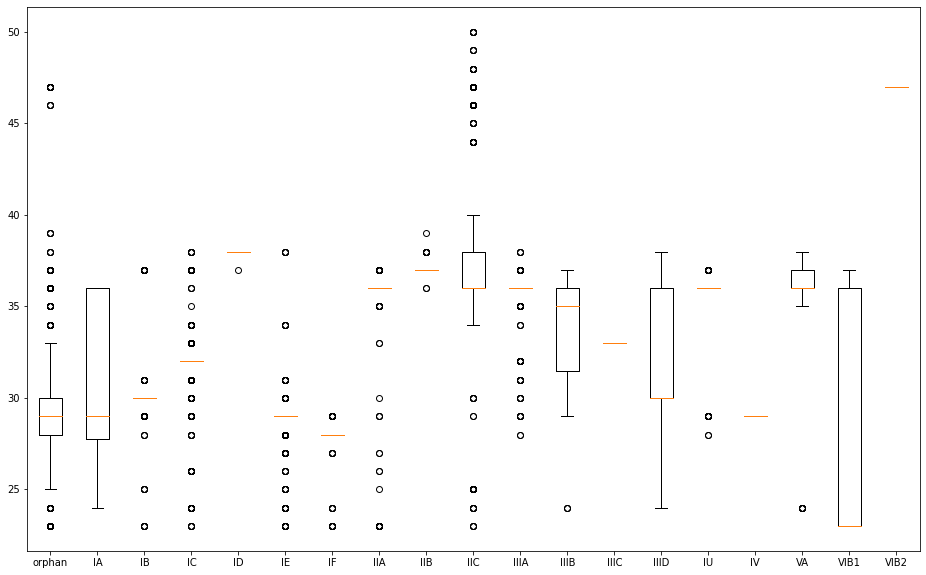

In [30]:
# boxplot
data_plot = [seq_sk_PCA['Length'][i] for i in label_order]
fig, ax = plt.subplots(figsize=(16,10))
ax.boxplot(data_plot)
plt.xticks(range(1,len(label_order)+1),label_order)
plt.show()
fig.savefig('CRISPR_DR_PublicParis_boxplot_length.pdf')
# fig1.savefig('CRISPR_DR_PublicParis_boxplot_length.png')

/Users/jinenstar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


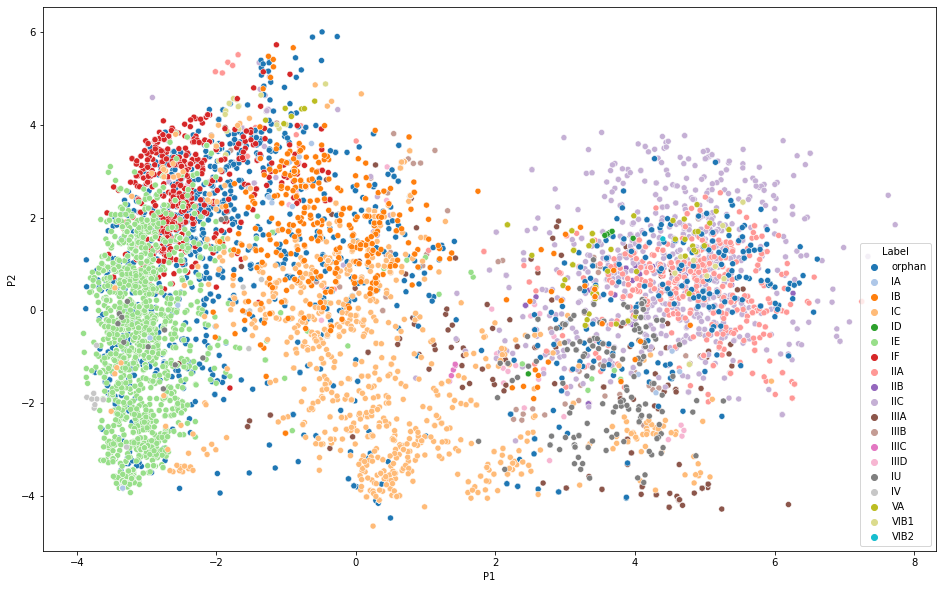

In [45]:
# plot sequences by Cas 
fig = plt.figure(figsize=(16,10))
sns.scatterplot("P1", "P2", hue="Label", hue_order=label_order, data=seq_sk_PCA, palette="tab20")
plt.show()
fig.savefig('CRISPR_DR_PublicParis_PCA_Python.pdf')

/Users/jinenstar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


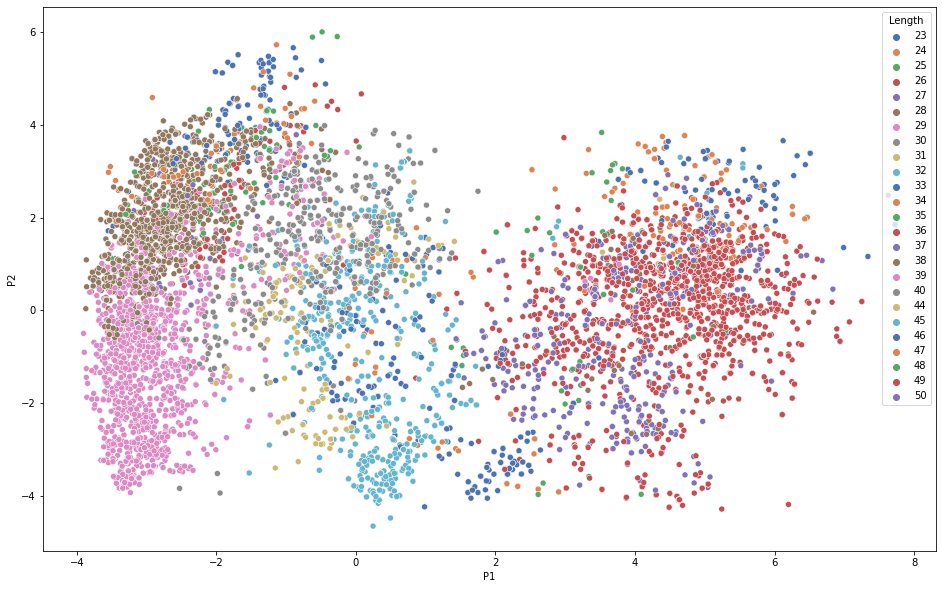

In [46]:
# plot sequences by length
fig = plt.figure(figsize=(16,10))
sns.scatterplot("P1", "P2", hue="Length", data=seq_sk_PCA, palette="deep")
plt.show()
fig.savefig('CRISPR_DR_PublicParis_PCA_Python_length.pdf')

# Clustering algorithm
- use GMM clustering in latent dimension

In [245]:
x_enc_1 = seq_sk_PCA[{'P1','P2'}].to_numpy()

In [246]:
# Gaussian Mixture Model (GMM)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_s = ['spherical', 'tied', 'diag', 'full']
for cv_ in cv_s:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,covariance_type=cv_)
        gmm.fit(x_enc_1)
        bic.append(gmm.bic(x_enc_1))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

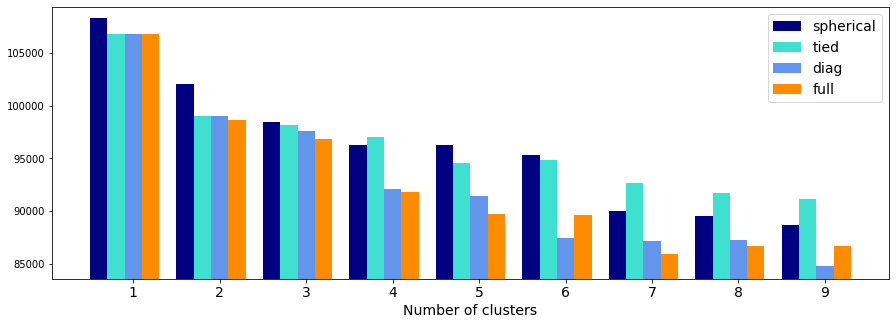

In [247]:
# Plot the BIC scores
fig = plt.figure(figsize=(15, 5))
#spl = plt.subplot(2, 1, 1)
for i, (cv_, color) in enumerate(zip(cv_s, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.ylim([bic.min() * 1.05 - .05 * bic.max(), bic.max() * 1.01])
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.xlabel('Number of clusters', fontsize=14)
plt.legend([b[0] for b in bars], cv_s, fontsize=14)

fig.savefig('CRISPR_DR_PublicParis_Python_GMM_BIC.pdf')

In [248]:
# winner as component = 5
n_clusters=5
Gmix = GaussianMixture(n_clusters, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10).fit_predict(x_enc_1)

In [249]:
Gmix[:100]

array([0, 4, 4, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0,
       3, 3, 0, 2, 4, 4, 3, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 2, 2,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [250]:
seq_sk_PCA["Gmix"] = Gmix

In [251]:
seq_sk_PCA

,P1,P2,P3,Length,Seq,Label,ID,Gmix
IIID,4.672813,-2.706232,-1.645987,36,GTCTTAATCCCGTTTGGGAATCGGGCGTGGTCGAAC,IIID,CP059256.1,0
IIID,4.477078,-2.781661,-1.002418,36,GTCTTAATCCCGTTTGGGAATCGGGCGCGGTCGAAC,IIID,CP059256.1,4
IIID,2.775133,-3.233113,-1.395849,36,GTCTTCATCCCGTCTGGGAATCGGGCGTGTTGAACA,IIID,CP059256.1,4
IIID,4.660003,-2.470568,-0.667504,36,GTCTTAATCCCGTTTGGGAATTGGGCGCGGTCGAAC,IIID,CP059256.1,0
IIID,4.700479,-2.583166,-1.617767,36,ATCTTAATCCCGTTTGGGAATCGGGCGTGGTCGAAC,IIID,CP059256.1,0
...,...,...,...,...,...,...,...,...
IB,0.200793,0.360848,-0.444075,30,GTTTCCATTCCTCGTAGGTAGGCTGGGAAC,IB,AP013035.1,2
IB,0.147078,2.859799,1.270846,30,ATTTCCACATTACTTACAAGGAATTGAAAC,IB,AP017470.1,2
IB,-0.295509,0.801413,1.305826,30,CTTTCCACACTACCTACAAGGAATTGAAAC,IB,AP017470.1,2
IB,-0.095086,1.836637,1.529341,30,ATTTCCACATTACCTACAAGGAATTGAAAC,IB,AP017470.1,2


/Users/jinenstar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


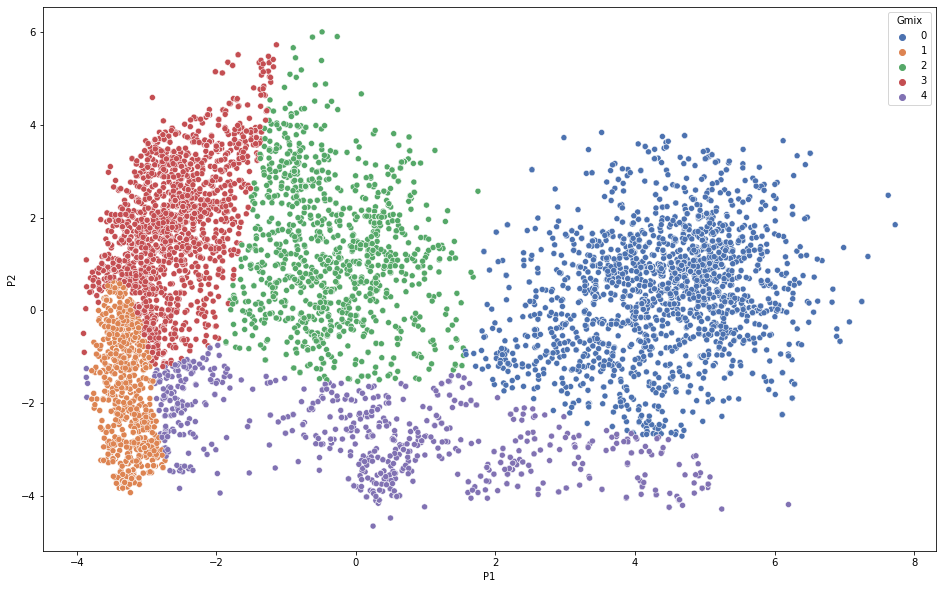

In [252]:
# plot test sequences by cluster
fig = plt.figure(figsize=(16,10))
sns.scatterplot("P1", "P2", hue="Gmix", data=seq_sk_PCA, palette="deep")
plt.show()
fig.savefig('CRISPR_DR_PublicParis_PCA_Python_GMM.pdf')

In [253]:
#calculate mean and stdev of length by cluster
length_cluster = {}
for n in range(n_clusters):
    dat_cluster = seq_sk_PCA.loc[seq_sk_PCA['Gmix']==n]
    length_cluster.update({n:(calculate_cluster_mean(dat_cluster),calculate_cluster_stdev(dat_cluster))})
length_cluster

{0: (37.34740691489362, 3.3819076804383212),
 1: (28.967818267865592, 0.21739204284225097),
 2: (30.442972350230416, 2.1094482476044547),
 3: (27.590093323761664, 1.636202479836111),
 4: (32.722183828610916, 2.6065559831761242)}

In [254]:
#calculate GC content by cluster
GC_content_cluster = {}
for n in range(n_clusters):
    dat_cluster = seq_sk_PCA.loc[seq_sk_PCA['Gmix']==n]
    dat_cluster_seq = dat_cluster["Seq"].tolist()
    GC_content_cluster.update({n:calculate_GC_content(dat_cluster_seq)})
GC_content_cluster

{0: (0.6612449152252151, 0.4156828345375015),
 1: (2.1913063142357982, 0.52002200423321),
 2: (0.9279018696890743, 0.6746991067739176),
 3: (1.4600547052461645, 0.7465945499298561),
 4: (1.690984552999162, 0.6033161516237698)}

In [255]:
#calculate Entropy by cluster
Shannon_E_cluster = {}
for n in range(n_clusters):
    dat_cluster = seq_sk_PCA.loc[seq_sk_PCA['Gmix']==n]
    dat_cluster_seq = dat_cluster["Seq"].tolist()
    Shannon_E_cluster.update({n:calculate_Shannon_E(dat_cluster_seq)})
Shannon_E_cluster

{0: (0.049920820313397785, 0.004709574122275936),
 1: (0.0648154534076797, 0.002124083408760711),
 2: (0.06099917649851255, 0.005282982441084397),
 3: (0.06997121551352803, 0.005015582792255074),
 4: (0.058097901898977636, 0.005893445112148427)}

In [256]:
Gmix0=seq_sk_PCA.loc[seq_sk_PCA['Gmix']==0]
Gmix0.to_csv('seq_sk_Gmix0.txt',sep='\t')

with open('seq_sk_Gmix0.fasta', 'w') as f:
    for n in range(len(Gmix0)):
        f.write(">" + Gmix0['ID'][n] + "\n" + str(Gmix0['Seq'][n] + "\n"))

In [257]:
Gmix1=seq_sk_PCA.loc[seq_sk_PCA['Gmix']==1]
Gmix1.to_csv('seq_sk_Gmix1.txt',sep='\t')

with open('seq_sk_Gmix1.fasta', 'w') as f:
    for n in range(len(Gmix1)):
        f.write(">" + Gmix1['ID'][n] + "\n" + str(Gmix1['Seq'][n] + "\n"))

In [258]:
Gmix2=seq_sk_PCA.loc[seq_sk_PCA['Gmix']==2]
Gmix2.to_csv('seq_sk_Gmix2.txt',sep='\t')

with open('seq_sk_Gmix2.fasta', 'w') as f:
    for n in range(len(Gmix2)):
        f.write(">" + Gmix2['ID'][n] + "\n" + str(Gmix2['Seq'][n] + "\n"))

In [259]:
Gmix3=seq_sk_PCA.loc[seq_sk_PCA['Gmix']==3]
Gmix3.to_csv('seq_sk_Gmix3.txt',sep='\t')

with open('seq_sk_Gmix3.fasta', 'w') as f:
    for n in range(len(Gmix3)):
        f.write(">" + Gmix3['ID'][n] + "\n" + str(Gmix3['Seq'][n] + "\n"))

In [260]:
Gmix4=seq_sk_PCA.loc[seq_sk_PCA['Gmix']==4]
Gmix4.to_csv('seq_sk_Gmix4.txt',sep='\t')

with open('seq_sk_Gmix4.fasta', 'w') as f:
    for n in range(len(Gmix4)):
        f.write(">" + Gmix4['ID'][n] + "\n" + str(Gmix4['Seq'][n] + "\n"))

In [159]:
# Gmix5=seq_sk_PCA.loc[seq_sk_PCA['Gmix']==5]
# Gmix5.to_csv('seq_sk_Gmix5.txt',sep='\t')

# with open('seq_sk_Gmix5.fasta', 'w') as f:
#     for n in range(len(Gmix5)):
#         f.write(">" + Gmix5['ID'][n] + "\n" + str(Gmix5['Seq'][n] + "\n"))

In [79]:
# Gmix6=seq_sk_PCA.loc[seq_sk_PCA['Gmix']==6]
# Gmix6.to_csv('seq_sk_Gmix6.txt',sep='\t')

# with open('seq_sk_Gmix6.fasta', 'w') as f:
#     for n in range(len(Gmix6)):
#         f.write(">" + Gmix6['ID'][n] + "\n" + str(Gmix6['Seq'][n] + "\n"))

In [80]:
# Gmix7=seq_sk_PCA.loc[seq_sk_PCA['Gmix']==7]
# Gmix7.to_csv('seq_sk_Gmix7.txt',sep='\t')

# with open('seq_sk_Gmix7.fasta', 'w') as f:
#     for n in range(len(Gmix7)):
#         f.write(">" + Gmix7['ID'][n] + "\n" + str(Gmix7['Seq'][n] + "\n"))

In [261]:
print(len(Gmix0))
print(len(Gmix1))
print(len(Gmix2))
print(len(Gmix3))
print(len(Gmix4))
#print(len(Gmix5))
# print(len(Gmix6))
# print(len(Gmix7))

3008
2113
1736
2786
1447


In [262]:
len(Gmix0)+len(Gmix1)+len(Gmix2)+len(Gmix3)+len(Gmix4)#+len(Gmix5)+len(Gmix6)+len(Gmix7)

11090

# Extract MFE values
- extract MFE values from RNAfold output files

In [263]:
# for f in datapath.glob("*.fasta"):
#     all_repeat_ID = []
#     all_repeat_seq = []
#     for record in SeqIO.parse(str(f), "fasta"):
#         all_repeat_ID.append(record.id)
#         all_repeat_seq.append(record.seq)

all_mfe_data = {}
all_mfe_mfe = []
all_mfe_ID = []

# Load test sequences
for f in datapath.glob("RNAfold*.fa"):
    records = list(SeqIO.parse(str(f), "fasta"))
    key = f.stem
    all_mfe_data[key] = extract_dataset_mfe(records)
    all_mfe_ID.extend(all_mfe_data[key]["ID"])
    all_mfe_mfe.extend(all_mfe_data[key]["MFE"])  

In [264]:
all_mfe_data.keys()

dict_keys(['RNAfold_Gmix1.txt', 'RNAfold_Gmix3.txt', 'RNAfold_Gmix4.txt', 'RNAfold_Gmix0.txt', 'RNAfold_Gmix2.txt'])

In [265]:
MFE_0 = [float(i) for i in all_mfe_data['RNAfold_Gmix0.txt']['MFE']]
print(mean(MFE_0))
print(stdev(MFE_0))

-4.132277260638298
4.570692991214973


In [266]:
MFE_1 = [float(i) for i in all_mfe_data['RNAfold_Gmix1.txt']['MFE']]
print(mean(MFE_1))
print(stdev(MFE_1))

-13.572976810222432
2.0988415563646874


In [267]:
MFE_2 = [float(i) for i in all_mfe_data['RNAfold_Gmix2.txt']['MFE']]
print(mean(MFE_2))
print(stdev(MFE_2))

-6.7281682027649765
5.769494085516982


In [268]:
MFE_3 = [float(i) for i in all_mfe_data['RNAfold_Gmix3.txt']['MFE']]
print(mean(MFE_3))
print(stdev(MFE_3))

-8.864931801866476
4.165490603783988


In [269]:
MFE_4 = [float(i) for i in all_mfe_data['RNAfold_Gmix4.txt']['MFE']]
print(mean(MFE_4))
print(stdev(MFE_4))

-11.530822391154112
3.3914020855767464


In [270]:
# MFE_5 = [float(i) for i in all_mfe_data['RNAfold_Gmix5.txt']['MFE']]
# print(mean(MFE_5))
# print(stdev(MFE_5))

In [271]:
# MFE_6 = [float(i) for i in all_mfe_data['RNAfold_Gmix6.txt']['MFE']]
# print(mean(MFE_6))
# print(stdev(MFE_6))

In [272]:
# MFE_7 = [float(i) for i in all_mfe_data['RNAfold_Gmix7.txt']['MFE']]
# print(mean(MFE_7))
# print(stdev(MFE_7))